In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

In [20]:
def balanced_batch_generator_reg(data, labels, M, K):
    """
    Generates K batches of data and associated labels, each of size M, ensuring
    that each data point appears in at least one batch.

    Parameters:
    - data (numpy.array): The dataset.
    - labels (numpy.array): Corresponding labels for the dataset.
    - M (int): Batch size.
    - K (int): Number of batches.

    Yields:
    - tuple: Batches of data and corresponding labels.
    """

    # Get total number of data samples
    num_samples = len(data)

    # Initialize a set to track unique batches
    selected_batches = set()

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            if i + M >= num_samples: break # (removes last batch if needed)

            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K: break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

# Define the neural network for regression
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.output(x)
        return x

## California Housing Dataset

In [21]:
torch.manual_seed(42)

# Load the California Housing dataset
housing = fetch_california_housing()
X_data, y_data = housing.data, housing.target

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [22]:
# Training and evaluation settings
iterations = 5
num_epochs = 2000
batch_size = 100

mse_train_array = np.zeros((num_epochs, iterations))
mse_test_array = np.zeros((num_epochs, iterations))
mse_time_array = np.zeros((num_epochs, iterations))

criterion = nn.MSELoss()

for i in range(iterations):
    model_mse = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_mse = 0;
        # Training loop for MSE
        model_mse.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in train_dataloader:
            optimizer_mse.zero_grad()
            outputs = model_mse(batch_X)
            loss_mse = criterion(outputs, batch_y)

            loss_mse.backward()
            optimizer_mse.step()
            epoch_loss_mse += loss_mse.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_mse.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mse = model_mse(X_test)
            mse_test = criterion(predictions_mse, y_test)
            mse_train_array[epoch, i] = epoch_loss_mse / len(train_dataloader)
            mse_test_array[epoch, i] = mse_test
            mse_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MSE: {mse_test:.4f}, MSE Time: {total_training_time:.2f} seconds')

Streaming output truncated to the last 5000 lines.
Iteration: 3, Epoch: 1001, Test MSE: 1.4007, MSE Time: 254.93 seconds
Iteration: 3, Epoch: 1002, Test MSE: 1.3991, MSE Time: 255.16 seconds
Iteration: 3, Epoch: 1003, Test MSE: 1.3995, MSE Time: 255.39 seconds
Iteration: 3, Epoch: 1004, Test MSE: 1.3953, MSE Time: 255.62 seconds
Iteration: 3, Epoch: 1005, Test MSE: 1.3978, MSE Time: 255.85 seconds
Iteration: 3, Epoch: 1006, Test MSE: 1.3995, MSE Time: 256.08 seconds
Iteration: 3, Epoch: 1007, Test MSE: 1.3983, MSE Time: 256.33 seconds
Iteration: 3, Epoch: 1008, Test MSE: 1.3968, MSE Time: 256.55 seconds
Iteration: 3, Epoch: 1009, Test MSE: 1.3954, MSE Time: 256.77 seconds
Iteration: 3, Epoch: 1010, Test MSE: 1.4011, MSE Time: 257.01 seconds
Iteration: 3, Epoch: 1011, Test MSE: 1.3976, MSE Time: 257.25 seconds
Iteration: 3, Epoch: 1012, Test MSE: 1.3960, MSE Time: 257.49 seconds
Iteration: 3, Epoch: 1013, Test MSE: 1.3941, MSE Time: 257.72 seconds
Iteration: 3, Epoch: 1014, Test MSE: 1.

In [23]:
# Training and evaluation settings
iterations = 5
num_epochs = 140
batch_size = 100
num_batches = 2000

rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))
rlp_time_array = np.zeros((num_epochs, iterations))
criterion = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_rlp = 0;
        # Training loop for RLP
        model_rlp.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion(batch_X @ c_pred, batch_X @ c) # RLP Loss

            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_rlp = model_rlp(X_test)
            rlp_test = criterion(predictions_rlp, y_test)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            rlp_test_array[epoch, i] = rlp_test
            rlp_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, RLP Test MSE: {rlp_test:.4f}, RLP Time: {total_training_time:.2f} seconds')

Iteration: 1, Epoch: 1, RLP Test MSE: 316.0790, RLP Time: 3.42 seconds
Iteration: 1, Epoch: 2, RLP Test MSE: 72.6683, RLP Time: 6.68 seconds
Iteration: 1, Epoch: 3, RLP Test MSE: 16.0122, RLP Time: 10.07 seconds
Iteration: 1, Epoch: 4, RLP Test MSE: 11.8483, RLP Time: 14.52 seconds
Iteration: 1, Epoch: 5, RLP Test MSE: 10.0637, RLP Time: 17.86 seconds
Iteration: 1, Epoch: 6, RLP Test MSE: 8.5004, RLP Time: 21.17 seconds
Iteration: 1, Epoch: 7, RLP Test MSE: 7.1882, RLP Time: 25.18 seconds
Iteration: 1, Epoch: 8, RLP Test MSE: 6.1039, RLP Time: 29.25 seconds
Iteration: 1, Epoch: 9, RLP Test MSE: 5.2310, RLP Time: 32.42 seconds
Iteration: 1, Epoch: 10, RLP Test MSE: 4.5496, RLP Time: 35.70 seconds
Iteration: 1, Epoch: 11, RLP Test MSE: 4.0364, RLP Time: 40.13 seconds
Iteration: 1, Epoch: 12, RLP Test MSE: 3.6667, RLP Time: 43.38 seconds
Iteration: 1, Epoch: 13, RLP Test MSE: 3.4090, RLP Time: 46.66 seconds
Iteration: 1, Epoch: 14, RLP Test MSE: 3.2287, RLP Time: 49.87 seconds
Iteration: 

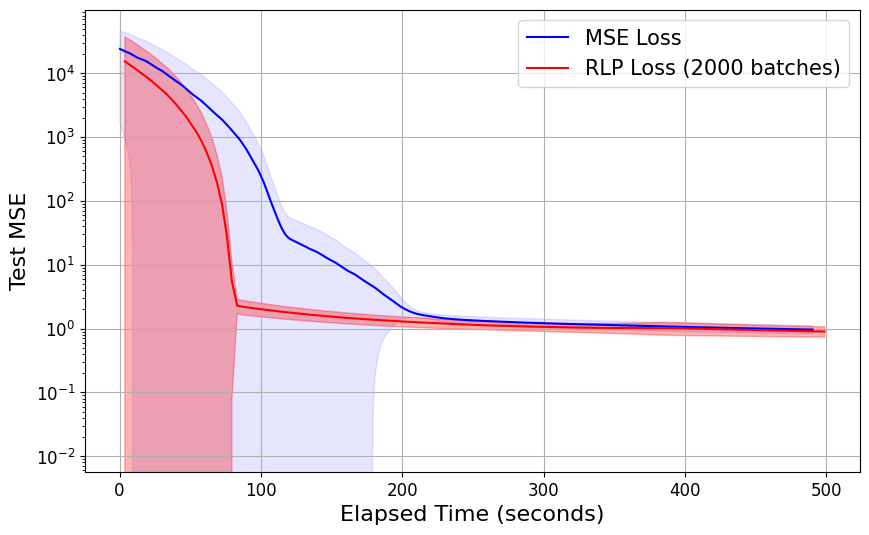

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and 95% confidence interval
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)  # Mean across iterations for each epoch
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI
    return mean, ci

# Computing means and CIs for test arrays
mean_X, ci_X = compute_mean_and_CI(mse_test_array[:1850,:])
mean_Z, ci_Z = compute_mean_and_CI(rlp_test_array)

# Computing mean time for plotting
mean_time_X = np.mean(mse_time_array[:1850,:], axis=1)  # Mean time for MSE
mean_time_Z = np.mean(rlp_time_array, axis=1)  # Mean time for RLP

# Plotting
plt.figure(figsize=(10, 6))

# MSE Loss plot
plt.fill_between(mean_time_X, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1)
plt.plot(mean_time_X, mean_X, 'b-', label="MSE Loss")

# RLP Loss plot
plt.fill_between(mean_time_Z, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3)
plt.plot(mean_time_Z, mean_Z, 'r-', label="RLP Loss (2000 batches)")

# Additional plot settings
plt.xlabel("Elapsed Time (seconds)", fontsize=16)
plt.ylabel("Test MSE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()

## Wine Quality Dataset

In [31]:
torch.manual_seed(42)

# Load the California Housing dataset
wine = fetch_openml(name='wine_quality', version=1, parser='auto')
X_data, y_data = wine.data.to_numpy(), np.expand_dims(wine.target.to_numpy(),1)

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [35]:
# Training and evaluation settings
iterations = 5
num_epochs = 4000
batch_size = 100

mse_train_array = np.zeros((num_epochs, iterations))
mse_test_array = np.zeros((num_epochs, iterations))
mse_time_array = np.zeros((num_epochs, iterations))

criterion = nn.MSELoss()

for i in range(iterations):
    model_mse = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_mse = 0;
        # Training loop for MSE
        model_mse.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in train_dataloader:
            optimizer_mse.zero_grad()
            outputs = model_mse(batch_X)
            loss_mse = criterion(outputs, batch_y)

            loss_mse.backward()
            optimizer_mse.step()
            epoch_loss_mse += loss_mse.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_mse.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mse = model_mse(X_test)
            mse_test = criterion(predictions_mse, y_test)
            mse_train_array[epoch, i] = epoch_loss_mse / len(train_dataloader)
            mse_test_array[epoch, i] = mse_test
            mse_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MSE: {mse_test:.4f}, MSE Time: {total_training_time:.2f} seconds')

Streaming output truncated to the last 5000 lines.
Iteration: 4, Epoch: 3001, Test MSE: 0.7735, MSE Time: 269.86 seconds
Iteration: 4, Epoch: 3002, Test MSE: 0.7734, MSE Time: 269.94 seconds
Iteration: 4, Epoch: 3003, Test MSE: 0.7734, MSE Time: 270.02 seconds
Iteration: 4, Epoch: 3004, Test MSE: 0.7733, MSE Time: 270.08 seconds
Iteration: 4, Epoch: 3005, Test MSE: 0.7732, MSE Time: 270.17 seconds
Iteration: 4, Epoch: 3006, Test MSE: 0.7731, MSE Time: 270.25 seconds
Iteration: 4, Epoch: 3007, Test MSE: 0.7730, MSE Time: 270.31 seconds
Iteration: 4, Epoch: 3008, Test MSE: 0.7729, MSE Time: 270.39 seconds
Iteration: 4, Epoch: 3009, Test MSE: 0.7729, MSE Time: 270.45 seconds
Iteration: 4, Epoch: 3010, Test MSE: 0.7728, MSE Time: 270.53 seconds
Iteration: 4, Epoch: 3011, Test MSE: 0.7727, MSE Time: 270.60 seconds
Iteration: 4, Epoch: 3012, Test MSE: 0.7727, MSE Time: 270.67 seconds
Iteration: 4, Epoch: 3013, Test MSE: 0.7726, MSE Time: 270.74 seconds
Iteration: 4, Epoch: 3014, Test MSE: 0.

In [33]:
# Training and evaluation settings
iterations = 5
num_epochs = 100
batch_size = 100
num_batches = 2000

rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))
rlp_time_array = np.zeros((num_epochs, iterations))
criterion = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_rlp = 0;
        # Training loop for RLP
        model_rlp.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion(batch_X @ c_pred, batch_X @ c) # RLP Loss

            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_rlp = model_rlp(X_test)
            rlp_test = criterion(predictions_rlp, y_test)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            rlp_test_array[epoch, i] = rlp_test
            rlp_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, RLP Test MSE: {rlp_test:.4f}, RLP Time: {total_training_time:.2f} seconds')

Iteration: 1, Epoch: 1, RLP Test MSE: 265.4389, RLP Time: 4.58 seconds
Iteration: 1, Epoch: 2, RLP Test MSE: 230.0885, RLP Time: 8.34 seconds
Iteration: 1, Epoch: 3, RLP Test MSE: 197.5564, RLP Time: 11.94 seconds
Iteration: 1, Epoch: 4, RLP Test MSE: 167.6378, RLP Time: 16.43 seconds
Iteration: 1, Epoch: 5, RLP Test MSE: 140.2164, RLP Time: 19.90 seconds
Iteration: 1, Epoch: 6, RLP Test MSE: 115.2556, RLP Time: 23.44 seconds
Iteration: 1, Epoch: 7, RLP Test MSE: 92.7528, RLP Time: 27.13 seconds
Iteration: 1, Epoch: 8, RLP Test MSE: 72.7340, RLP Time: 31.45 seconds
Iteration: 1, Epoch: 9, RLP Test MSE: 55.2281, RLP Time: 35.35 seconds
Iteration: 1, Epoch: 10, RLP Test MSE: 40.2551, RLP Time: 38.75 seconds
Iteration: 1, Epoch: 11, RLP Test MSE: 27.8578, RLP Time: 43.12 seconds
Iteration: 1, Epoch: 12, RLP Test MSE: 18.0415, RLP Time: 46.63 seconds
Iteration: 1, Epoch: 13, RLP Test MSE: 10.7886, RLP Time: 50.02 seconds
Iteration: 1, Epoch: 14, RLP Test MSE: 6.0105, RLP Time: 53.80 second

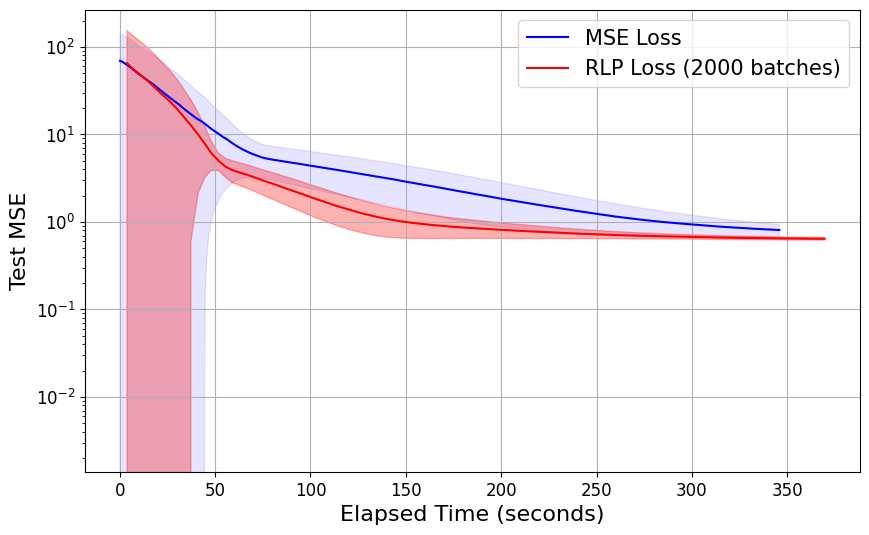

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and 95% confidence interval
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)  # Mean across iterations for each epoch
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI
    return mean, ci

# Computing means and CIs for test arrays
mean_X, ci_X = compute_mean_and_CI(mse_test_array)
mean_Z, ci_Z = compute_mean_and_CI(rlp_test_array)

# Computing mean time for plotting
mean_time_X = np.mean(mse_time_array, axis=1)  # Mean time for MSE
mean_time_Z = np.mean(rlp_time_array, axis=1)  # Mean time for RLP

# Plotting
plt.figure(figsize=(10, 6))

# MSE Loss plot
plt.fill_between(mean_time_X, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1)
plt.plot(mean_time_X, mean_X, 'b-', label="MSE Loss")

# RLP Loss plot
plt.fill_between(mean_time_Z, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3)
plt.plot(mean_time_Z, mean_Z, 'r-', label="RLP Loss (2000 batches)")

# Additional plot settings
plt.xlabel("Elapsed Time (seconds)", fontsize=16)
plt.ylabel("Test MSE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()

## Nonlinear Dataset

In [11]:
torch.manual_seed(42)

# MULTIDIMENSIONAL DATASET
rng = np.random.RandomState(1)
X = rng.rand(6000, 7) # Same dataset will now be used across different trials
y = np.expand_dims((X[:,0] + X[:,1]**2 + X[:,2]**3 + X[:,3]**4 + X[:,4]**5 + np.exp(X[:,5]) + np.sin(X[:,6])), 1)
X_data, y_data = X, y

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [17]:
# Training and evaluation settings
iterations = 5
num_epochs = 4600
batch_size = 100

mse_train_array = np.zeros((num_epochs, iterations))
mse_test_array = np.zeros((num_epochs, iterations))
mse_time_array = np.zeros((num_epochs, iterations))

criterion = nn.MSELoss()

for i in range(iterations):
    model_mse = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_mse = 0;
        # Training loop for MSE
        model_mse.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in train_dataloader:
            optimizer_mse.zero_grad()
            outputs = model_mse(batch_X)
            loss_mse = criterion(outputs, batch_y)

            loss_mse.backward()
            optimizer_mse.step()
            epoch_loss_mse += loss_mse.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_mse.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mse = model_mse(X_test)
            mse_test = criterion(predictions_mse, y_test)
            mse_train_array[epoch, i] = epoch_loss_mse / len(train_dataloader)
            mse_test_array[epoch, i] = mse_test
            mse_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MSE: {mse_test:.4f}, MSE Time: {total_training_time:.2f} seconds')

Streaming output truncated to the last 5000 lines.
Iteration: 4, Epoch: 4201, Test MSE: 1.2558, MSE Time: 314.00 seconds
Iteration: 4, Epoch: 4202, Test MSE: 1.2539, MSE Time: 314.06 seconds
Iteration: 4, Epoch: 4203, Test MSE: 1.2519, MSE Time: 314.12 seconds
Iteration: 4, Epoch: 4204, Test MSE: 1.2500, MSE Time: 314.19 seconds
Iteration: 4, Epoch: 4205, Test MSE: 1.2481, MSE Time: 314.27 seconds
Iteration: 4, Epoch: 4206, Test MSE: 1.2462, MSE Time: 314.33 seconds
Iteration: 4, Epoch: 4207, Test MSE: 1.2443, MSE Time: 314.39 seconds
Iteration: 4, Epoch: 4208, Test MSE: 1.2424, MSE Time: 314.45 seconds
Iteration: 4, Epoch: 4209, Test MSE: 1.2405, MSE Time: 314.53 seconds
Iteration: 4, Epoch: 4210, Test MSE: 1.2386, MSE Time: 314.59 seconds
Iteration: 4, Epoch: 4211, Test MSE: 1.2367, MSE Time: 314.65 seconds
Iteration: 4, Epoch: 4212, Test MSE: 1.2348, MSE Time: 314.71 seconds
Iteration: 4, Epoch: 4213, Test MSE: 1.2329, MSE Time: 314.79 seconds
Iteration: 4, Epoch: 4214, Test MSE: 1.

In [15]:
# Training and evaluation settings
iterations = 5
num_epochs = 100
batch_size = 100
num_batches = 2000

rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))
rlp_time_array = np.zeros((num_epochs, iterations))
criterion = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))
    total_training_time = 0  # Initialize total training time

    for epoch in range(num_epochs):
        epoch_loss_rlp = 0;
        # Training loop for RLP
        model_rlp.train()
        start_time = time.time()  # Start time for the training loop
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion(batch_X @ c_pred, batch_X @ c) # RLP Loss

            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        end_time = time.time()  # End time for the training loop
        training_time_this_epoch = end_time - start_time
        total_training_time += training_time_this_epoch

        # Evaluation on training set
        model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_rlp = model_rlp(X_test)
            rlp_test = criterion(predictions_rlp, y_test)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            rlp_test_array[epoch, i] = rlp_test
            rlp_time_array[epoch, i] = total_training_time

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, RLP Test MSE: {rlp_test:.4f}, RLP Time: {total_training_time:.2f} seconds')

Iteration: 1, Epoch: 1, RLP Test MSE: 14.2580, RLP Time: 4.33 seconds
Iteration: 1, Epoch: 2, RLP Test MSE: 14.0603, RLP Time: 7.31 seconds
Iteration: 1, Epoch: 3, RLP Test MSE: 13.8651, RLP Time: 10.42 seconds
Iteration: 1, Epoch: 4, RLP Test MSE: 13.6722, RLP Time: 14.32 seconds
Iteration: 1, Epoch: 5, RLP Test MSE: 13.4815, RLP Time: 17.35 seconds
Iteration: 1, Epoch: 6, RLP Test MSE: 13.2929, RLP Time: 20.35 seconds
Iteration: 1, Epoch: 7, RLP Test MSE: 13.1063, RLP Time: 23.34 seconds
Iteration: 1, Epoch: 8, RLP Test MSE: 12.9214, RLP Time: 27.38 seconds
Iteration: 1, Epoch: 9, RLP Test MSE: 12.7383, RLP Time: 30.41 seconds
Iteration: 1, Epoch: 10, RLP Test MSE: 12.5565, RLP Time: 33.44 seconds
Iteration: 1, Epoch: 11, RLP Test MSE: 12.3761, RLP Time: 36.47 seconds
Iteration: 1, Epoch: 12, RLP Test MSE: 12.1970, RLP Time: 40.64 seconds
Iteration: 1, Epoch: 13, RLP Test MSE: 12.0191, RLP Time: 44.06 seconds
Iteration: 1, Epoch: 14, RLP Test MSE: 11.8421, RLP Time: 47.09 seconds
Ite

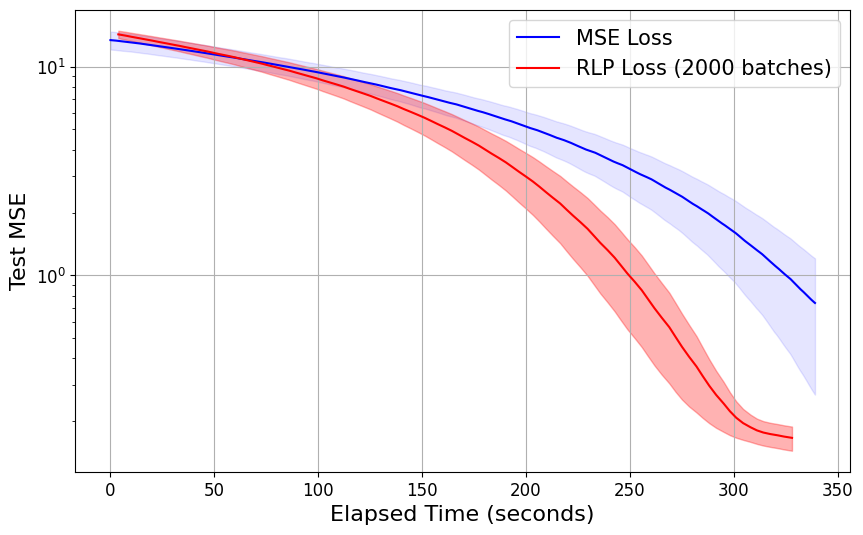

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and 95% confidence interval
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)  # Mean across iterations for each epoch
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI
    return mean, ci

# Computing means and CIs for test arrays
mean_X, ci_X = compute_mean_and_CI(mse_test_array)
mean_Z, ci_Z = compute_mean_and_CI(rlp_test_array)

# Computing mean time for plotting
mean_time_X = np.mean(mse_time_array, axis=1)  # Mean time for MSE
mean_time_Z = np.mean(rlp_time_array, axis=1)  # Mean time for RLP

# Plotting
plt.figure(figsize=(10, 6))

# MSE Loss plot
plt.fill_between(mean_time_X, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1)
plt.plot(mean_time_X, mean_X, 'b-', label="MSE Loss")

# RLP Loss plot
plt.fill_between(mean_time_Z, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3)
plt.plot(mean_time_Z, mean_Z, 'r-', label="RLP Loss (2000 batches)")

# Additional plot settings
plt.xlabel("Elapsed Time (seconds)", fontsize=16)
plt.ylabel("Test MSE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()